# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [2]:
#data = pd.read_csv('/Users/yakovlev/Downloads/Churn.csv')
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Узнаем, содержит ли датасет пропущенные значения и рассмотрим, какие имеются типы переменных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В столбце "Tenure" имеются пропущенные значения (около 10%). Заполним их медианой

Пропущенные значения заполним значением медианы

In [4]:
data.fillna(data['Tenure'].median(), inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Для создания ML модели нам понадобятся не все признаки датасета: качество предсказания не изменится в зависимости от фамилии клиента, RowNumber и CustomerId

In [5]:
data_prep = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data_prep

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Закодируем категориальные признаки методом OHE

In [6]:
data_prep = pd.get_dummies(data_prep, drop_first=True)
data_prep

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


Посмотрим на распределения

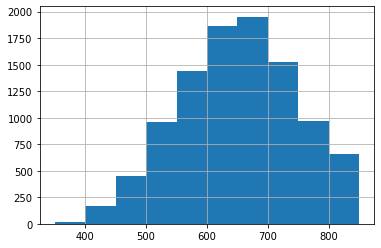

In [7]:
data['CreditScore'].hist()

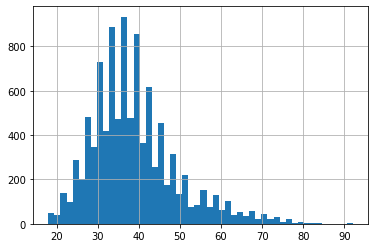

In [8]:
data['Age'].hist(bins=50)

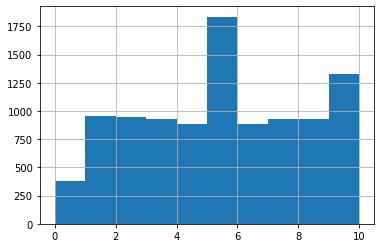

In [9]:
data['Tenure'].hist()

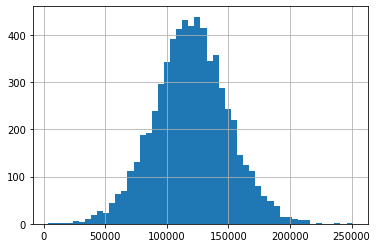

In [10]:
data.query('Balance != 0')['Balance'].hist(bins = 50)

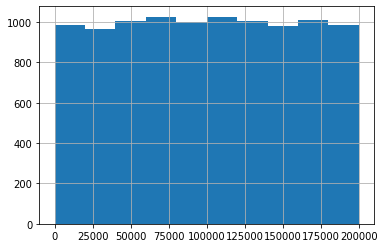

In [11]:
data['EstimatedSalary'].hist()

Выделим целевой и остальные признаки

In [12]:
target = data_prep['Exited']
feature = data_prep.drop('Exited', axis=1)

Разделим датасет на две выборки

In [13]:
feature_train, feature_valid, target_train, target_valid = train_test_split(feature, target,
                                                                           test_size=0.2)
print(feature_train.shape, target_train.shape)
print(feature_valid.shape, target_valid.shape)

(8000, 11) (8000,)
(2000, 11) (2000,)


Стандартизируем значения столбцов с количественными переменными

In [14]:
scaler = StandardScaler() 
columns = ['CreditScore', 'Age',  'Tenure', 'Balance', 'EstimatedSalary']
scaler.fit(feature_train[columns])
feature_train[columns] = scaler.transform(feature_train[columns])
feature_train

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
3313,0.339663,1.425821,0.367666,-1.225812,2,1,1,-0.084262,0,0,1
3945,0.060949,0.092911,1.815703,-1.225812,2,1,1,-0.813535,0,1,1
9366,0.876445,-0.287920,0.005656,-1.225812,1,1,0,-0.508827,0,0,0
1737,1.217095,-0.002297,1.453694,-1.225812,1,1,1,-0.905228,0,1,1
5396,-0.620351,0.283327,1.453694,1.362596,2,1,1,0.557415,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
9578,0.112563,-0.478336,-1.080372,0.659343,2,0,1,-0.776459,0,0,1
1096,1.082900,-0.002297,-0.718362,0.386911,3,1,1,-0.458186,1,0,0
130,1.103545,-0.478336,-0.718362,-1.225812,2,1,1,0.426387,0,0,0
3530,-2.044888,0.283327,0.005656,-1.225812,3,1,0,-0.291046,0,1,0


In [15]:
scaler.fit(feature_valid[columns])
feature_valid[columns] = scaler.transform(feature_valid[columns])
feature_valid

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9466,-0.932633,1.295284,-0.018914,-1.226016,1,1,0,0.476197,0,0,1
2353,-0.984875,-1.201649,0.708561,0.263751,2,1,0,1.579949,0,0,0
3716,0.174889,-1.105613,-1.110127,1.145788,1,0,0,1.489813,1,0,0
3607,0.352511,-0.145254,-0.018914,-1.226016,2,0,1,0.190990,0,0,1
2880,0.477891,-0.145254,1.072298,0.354019,2,1,0,1.400510,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4450,-0.159457,1.967535,-1.110127,0.446981,1,1,1,0.028179,0,0,1
501,0.456994,1.487356,-0.018914,-1.226016,2,1,1,-0.221996,0,0,1
8703,0.133096,-0.721470,-0.746389,0.962909,2,1,0,-0.623217,0,0,0
7655,1.042100,-0.049218,-0.382652,0.627551,1,0,1,-0.529837,0,0,1


## Вывод

Заполнили пропущенные значения медианой, выделили нужные нам признаки, воспользовались OHE кодированием и стандартизировали количественные признаки

# 2. Исследование задачи

Построим график, показывающий сколько ушло клиентов банка, а сколько осталось

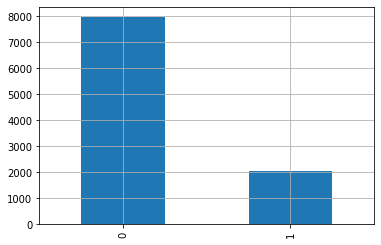

In [16]:
data_prep['Exited'].value_counts().plot(kind='bar', grid=True)

Как можем заметить, наблюдается дисбаланс классов: 0 встречается в 4 раза чаще, чем 1

Рассмотрим, какое значение F-1 смогут показать различные ML модели

**DecisionTreeClassifier**

Воспользуемся GridSearchCV для нахождения наилучших параметров

In [17]:
param_grid = {'max_depth': [x for x in range(1,25)],
             'random_state': [12345]}
gs = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, scoring='f1')

In [18]:
gs.fit(feature_train, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16

In [19]:
gs.best_params_

{'max_depth': 7, 'random_state': 12345}

In [20]:
gs.best_score_

0.5656045221329439

**RandomForestClassifier**

In [21]:
%%time
param_grid = {'max_depth': [depth for depth in range(5,25)], 
              'n_estimators': [30, 40, 100, 500],
             'random_state': [12345]}
gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring='f1')

CPU times: user 69 µs, sys: 6 µs, total: 75 µs
Wall time: 80.3 µs


In [22]:
gs.fit(feature_train, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [23]:
gs.best_params_

{'max_depth': 23, 'n_estimators': 500, 'random_state': 12345}

In [24]:
gs.best_score_

0.5747013124275031

**LogisticRegression**

In [25]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(feature_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

In [26]:
predict = model.predict(feature_valid)

In [27]:
f1 = f1_score(target_valid, predict)
f1

0.35675675675675683

## Вывод

Мы исследовали как отличаются друг от друга классы, а также посмотрели, какие результаты показывают различные модели без учета балансировки

# 3. Борьба с дисбалансом

Теперь разобьем датасет на три выборки - train, valid и test используя возможности библиотеки numpy

In [28]:
train, valid, test = np.split(data_prep.sample(frac=1), [int(.6*len(data_prep)), int(.8*len(data_prep))])

Выделим целевой и остальные признаки в каждой из выборок

In [29]:
feature_train = train.drop('Exited', axis=1)
target_train = train['Exited']

feature_valid = valid.drop('Exited', axis=1)
target_valid = valid['Exited']

feature_test = test.drop('Exited', axis=1)
target_test = test['Exited']

Посмотрим, что изменится, если мы сбалансируем классы (class_weight='balanced')

**DecisionTreeClassifier**

In [30]:
param_grid = {'max_depth': [x for x in range(1,25)],
             'class_weight': ['balanced'],
             'random_state': [12345]}
gs = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, scoring='f1')

In [31]:
gs.fit(feature_train, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12

In [32]:
gs.best_params_

{'class_weight': 'balanced', 'max_depth': 5, 'random_state': 12345}

In [33]:
gs.best_score_

0.5589629287987776

In [34]:
model = DecisionTreeClassifier(random_state=12345, max_depth=13, class_weight='balanced')
model.fit(feature_train, target_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=13,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

In [35]:
predict = model.predict(feature_valid)

In [36]:
f1_score(target_valid, predict)

0.556830031282586

Значение выросло, но оно все равно не дотягивает до 0.59

**RandomForestClassifier**

In [37]:
%%time
param_grid = {'n_estimators': [30, 40, 100, 500], 
              'max_depth': [depth for depth in range(5,25)],
              'class_weight': ['balanced'],
              'random_state': [12345]
              }
gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring='f1')

CPU times: user 64 µs, sys: 0 ns, total: 64 µs
Wall time: 70.1 µs


In [38]:
gs.fit(feature_train, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [39]:
gs.best_params_

{'class_weight': 'balanced',
 'max_depth': 8,
 'n_estimators': 500,
 'random_state': 12345}

In [40]:
gs.best_score_

0.6157422708235835

Значение выросло

**LogisticRegression**

In [41]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(feature_train, target_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

In [42]:
model.fit(feature_train, target_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

In [43]:
predict = model.predict(feature_valid)

In [44]:
f1_score(target_valid, predict)

0.5205254515599343

In [45]:
roc_auc_score(target_valid, predict)

0.7218300653594771

Линейная регрессия показала неутешительный результат при проверке метрики f-1, но достаточно хороший результат для roc_auc

Попробуем применить технику **upsampling**

In [46]:
train['Exited'].value_counts()

0    4784
1    1216
Name: Exited, dtype: int64

Значений "1" примерно в 4 раза меньше, чем "0"

In [47]:
feature_zero = feature_train[target_train == 0]
feature_one = feature_train[target_train == 1]
feature_upsampled = pd.concat([feature_zero] + [feature_one] * 4)
feature_upsampled = shuffle(feature_upsampled, random_state=12345)
feature_upsampled

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4460,661,35,5.0,0.00,1,1,0,155394.52,0,0,1
8726,697,43,8.0,103409.16,1,1,0,66893.28,1,0,1
133,686,25,1.0,0.00,2,0,1,16459.37,0,0,1
4483,539,38,8.0,105435.74,1,0,0,80575.44,1,0,0
2560,650,30,6.0,0.00,1,0,0,67997.13,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
7489,600,26,6.0,108909.12,1,1,0,82547.01,0,0,0
8922,550,35,9.0,129847.75,2,1,0,197325.40,1,0,1
9875,521,39,7.0,0.00,2,0,1,653.58,0,0,1
3609,850,40,6.0,94607.08,1,1,0,36690.49,1,0,1


In [48]:
target_zero = target_train[target_train == 0]
target_one = target_train[target_train == 1]
target_upsampled = pd.concat([target_zero] + [target_one] * 4)
target_upsampled = shuffle(target_upsampled, random_state=12345)
target_upsampled

4460    0
8726    1
133     0
4483    1
2560    1
       ..
7489    0
8922    0
9875    0
3609    0
6345    0
Name: Exited, Length: 9648, dtype: int64

Обучим модель на новых данных

In [49]:
%%time
param_grid = {'n_estimators': [30, 40, 100, 500], 
              'max_depth': [depth for depth in range(5,25)],
              'random_state': [12345]
              }
gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring='f1')

CPU times: user 86 µs, sys: 0 ns, total: 86 µs
Wall time: 107 µs


In [50]:
gs.fit(feature_upsampled, target_upsampled)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [51]:
gs.best_params_

{'max_depth': 21, 'n_estimators': 40, 'random_state': 12345}

In [52]:
gs.best_score_

0.9437290707752989

Получили удовлетворяющее значение F-1. Воспользуемся данной моделью для проверки на тестовой выборке

## Вывод

Обучили финальную модель с относительно высоким значением F-1

# 4. Тестирование модели

In [58]:
model = RandomForestClassifier(max_depth=21, n_estimators=40, random_state=12345)
model.fit(feature_upsampled, target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=21, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [59]:
predict = model.predict(feature_test)
f1_score(target_test, predict)

0.6192468619246861

In [60]:
roc_auc_score(target_test, predict)

0.7494426811758482

Достаточно высокое значение roc_auc_score. Модель обучена хорошо.

## Вывод

Значение F-1 на тестовой выборке больше 0.59.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*